In [3]:
import numpy as np
import pysindy as ps
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from sklearn.linear_model import Lasso
from pysindy.differentiation import SmoothedFiniteDifference

# Initialize integrator keywords for solve_ivp to replicate the odeint defaults
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12

In [4]:
def create_time_series(func, dt, t_end, init):
    t_train = np.arange(0, t_end, dt)
    t_train_span = (t_train[0], t_train[-1])
    # initial condition as a list of two entries: [x1, x2]
    x0_train = init
    x_train = solve_ivp(func, t_train_span, x0_train,
                    t_eval=t_train, **integrator_keywords).y.T
    return x_train

def find_equations(func, x_train, dt, plot):
    diff_method = SmoothedFiniteDifference(smoother_kws={'window_length': 5})
    opt = ps.optimizers.STLSQ(threshold=0.01, alpha = 0.1, max_iter=500, normalize_columns=True)
    # up to 3rd degree for van der pol
    lib = ps.PolynomialLibrary(degree=3).fit(x_train)
    model = ps.SINDy(optimizer=opt, 
                        feature_library=lib, 
                        differentiation_method=diff_method,
                        feature_names=['x1', 'x2'])
    model.fit(x_train, t=dt)
    model.print()
    print('Train Model score: %f' %model.score(x_train, dt))
    # Evolve the van der pol equations in time using a different initial condition
    t_test = np.arange(0, 20, dt)
    x0_test = np.array([0, 1.5])
    t_test_span = (t_test[0], t_test[-1])
    x_test = solve_ivp(func, t_test_span, x0_test,
                    t_eval=t_test, **integrator_keywords).y.T
    # Compare SINDy-predicted derivatives with finite difference derivatives
    print('Model score: %f' % model.score(x_test, t=dt))
    if plot:
        # Predict derivatives using the learned model
        x_dot_test_predicted = model.predict(x_test)

        # Compute derivatives with a finite difference method, for comparison
        x_dot_test_computed = model.differentiate(x_test, t=dt)

        fig, axs = plt.subplots(x_test.shape[1], 1, sharex=True, figsize=(7, 9))
        for i in range(x_test.shape[1]):
            axs[i].plot(t_test, x_dot_test_computed[:, i],
                        'k', label='numerical derivative')
            axs[i].plot(t_test, x_dot_test_predicted[:, i],
                        'r--', label='model prediction')
            axs[i].legend()
            axs[i].set(xlabel='t', ylabel='$\dot x_{}$'.format(i))
    return model

(x1)' = -1.000 x2
(x2)' = 1.000 x1 + -1.000 x2 + 1.000 x1^2 x2
Train Model score: 1.000000
Model score: 1.000000
(x1)' = -1.000 x2
(x2)' = 1.000 x1 + -1.000 x2 + 1.000 x1^2 x2
Train Model score: 1.000000
Model score: 1.000000
(x1)' = -1.000 x2
(x2)' = 1.000 x1 + -1.000 x2 + 1.000 x1^2 x2
Train Model score: 1.000000
Model score: 1.000000


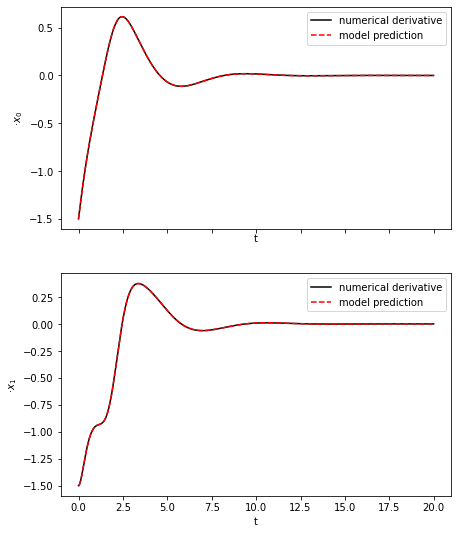

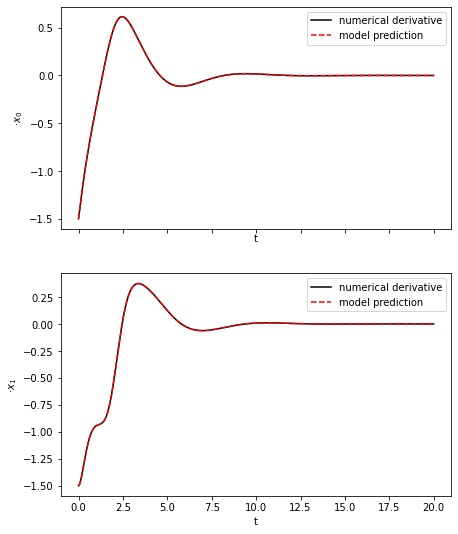

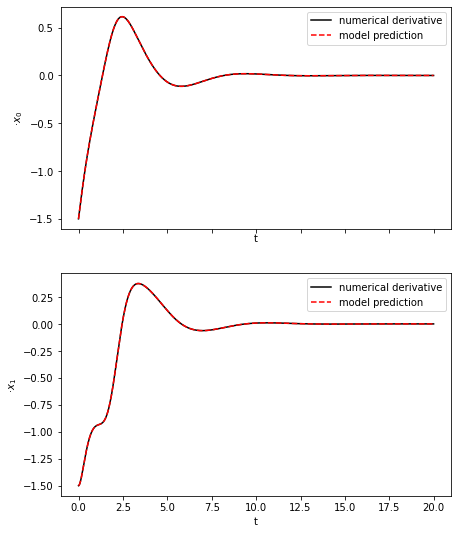

In [5]:
# Van der Pol ODE
def van_der_pol(t, x, p=[1]):
    return [-x[1], - p[0] * (1 - x[0] ** 2) * x[1] + x[0]]

dt = .01
t_end = 20
init = [[0, 2], [1, 2], [-0.5, 1.5]]
for ini in init:
    x_train = create_time_series(van_der_pol, dt, t_end, ini)
    model = find_equations(van_der_pol, x_train, dt, plot = True)
